# Benchmarking Notebook used for RQ3

In [1]:
# System imports
import sys
from os.path import join
from typing import List
sys.path.append("../")

# Import visualization and benchmarking tools
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Import data processing tools
from neuropack.utils import oavg
from neuropack.devices import BrainFlowDevice
from neuropack.preprocessing import PreprocessingPipeline, HighpassFilter
from neuropack.feature_extraction import AverageModel, PACModel, BandpowerModel
from neuropack.similarity_metrics import euclidean_similarity, bounded_cosine_similarity, cosine_similarity
from neuropack.benchmarking import auc, eer,load_dataset, extract_features, BenchmarkContainer

# SVM Benchmarking
from sklearn.linear_model import SGDClassifier as SVM
from sklearn.model_selection import GridSearchCV


# Setup

### Code for benchmarking and plotting classification-based configuration

In [2]:
def beautiful_benchmark_svm(classifiers: List[SVM], positives, negatives, title: str):
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    eers = []

    for i in range(len(classifiers)):
        y_true = np.hstack([np.zeros(len(negatives[i])), np.ones(len(positives[i]))])
        X_test = np.array(negatives[i] + positives[i])

        y_pred = classifiers[i].predict(X_test)

        # Calculate ROC and plot it
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        eers.append(eer(fpr, tpr))
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    eers = np.array(eers)

    print(f"Mean EER: {eers.mean()} +- {eers.std()}")
    print(f"EERs:" + " & ".join([f"${x*100:.2f}$" for x in eers]) + f"& ${eers.mean()*100:.2f} \pm {eers.std()*100:.2f}$\\\\")

    plt.plot(base_fpr, mean_tprs, 'b', label='Mean ROC (AUC = %0.2f)' % auc(base_fpr, mean_tprs))
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
 
    plt.grid()
    plt.plot([0, 1], [0, 1],'--',color="black")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'{title}')
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.savefig(f'{title}.png', dpi=600, bbox_inches='tight')
    plt.show()

def benchmark_svm(model, participant_data: List[BenchmarkContainer], title: str):  
    classifiers, positives, negatives = [], [], []

    for i in participant_data:
        # Create new list only containing data different from the current participant
        other = [x for x in participant_data if x.ident != i.ident]

        params = {
            "alpha" : [0.0001, 0.001, 0.01, 0.1],
            "penalty" : ["l2", "l1", "elasticnet", "none"],
        }

        # Create classifier
        classifier = SVM(loss="hinge", penalty="l2", max_iter=1000, random_state=0)
        classifier = GridSearchCV(classifier, params, cv=3, n_jobs=-1, verbose=0)

        # Train classifier in one-vs-all fashion
        positive_training = [model.extract_features(x) for x in i.template_epochs]
        negative_training = []
        for o in other:
            negative_training += [model.extract_features(x) for x in o.template_epochs]
        X_train = np.array(positive_training + negative_training)
        y_train = np.array([1] * len(positive_training) + [0] * len(negative_training))
        classifier.fit(X_train, y_train)
        
        # Create positive and negative samples
        negative_samples = extract_features(other, model, 1)
        positive_samples = extract_features([i], model, 1)

        # Append to lists
        classifiers.append(classifier)
        positives.append(positive_samples)
        negatives.append(negative_samples)
    
    # Perform benchmark
    return beautiful_benchmark_svm(classifiers, positives, negatives, title)

### Code for benchmarking and plotting similarity-based configuration

In [3]:
def beautiful_benchmark(templates, positives, negatives, similarity_metric, similarity_name: str):
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    eers = []

    for i in range(len(templates)):
        # Calculate similarity
        positive_sims = [similarity_metric(templates[i], x) for x in positives[i]]
        negative_sims = [similarity_metric(templates[i], x) for x in negatives[i]]

        # Create labels and scores
        scores = np.hstack([negative_sims, positive_sims])
        labels = np.hstack([np.zeros(len(negative_sims)), np.ones(len(positive_sims))])

        # Calculate ROC and plot it
        fpr, tpr, _ = roc_curve(labels, scores)
        eers.append(eer(fpr, tpr))
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0
        tprs.append(tpr)
    
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    eers = np.array(eers)

    print(f"Mean EER: {eers.mean()} +- {eers.std()}")
    print(f"EERs:" + " & ".join([f"${x*100:.2f}$" for x in eers]) + f"& ${eers.mean()*100:.2f} \pm {eers.std()*100:.2f}$\\\\")

    plt.plot(base_fpr, mean_tprs, 'b', label='Mean ROC (AUC = %0.2f)' % auc(base_fpr, mean_tprs))
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
 
    plt.grid()
    plt.plot([0, 1], [0, 1],'--',color="black")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(f'{similarity_name}')
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.savefig(f'{similarity_name}.png', dpi=600, bbox_inches='tight')
    plt.show()

def benchmark(model, participant_data, similarity_metric, similarity_name: str):  
    tempaltes, positives, negatives = [], [], []

    for i in participant_data:
        # Create new list only containing data different from the current participant
        other = [x for x in participant_data if x.ident != i.ident]

        # Calculate average for template
        avg_template = oavg(i.template_epochs)
        template = model.extract_features(avg_template)

        # Create positive and negative samples
        negative_samples = extract_features(other, model)
        positive_samples = extract_features([i], model)

        # Append to lists
        tempaltes.append(template)
        positives.append(positive_samples)
        negatives.append(negative_samples)
    
    # Perform benchmark
    return beautiful_benchmark(tempaltes, positives, negatives, similarity_metric, similarity_name)

### Collect all files

In [15]:
# Path to the extracted data
base_dir = "<path to datasets>"
ident = ["P1", "P2", "P3", "P4", "P5", "P6"]

# Create a dictionary containing the paths to the datasets
datasets = {x: [join(base_dir, x, "enrollment.csv")] + [join(base_dir, x, f"a{i}.csv") for i in range(1,5)] for x in ident}


# Data Preperation

In [10]:
pipeline = PreprocessingPipeline(HighpassFilter(0.1, 256))
original_data = [load_dataset(k, datasets[k][0], datasets[k][1:], epoch_length=(200, 800)) for k in datasets]
filtered_data = [load_dataset(k, datasets[k][0], datasets[k][1:], epoch_length=(200, 800), preprossessing=pipeline, artifact_removal=True) for k in datasets]

for i in range(len(original_data)):
    print(f"Original Data: {original_data[i]}")
    print(f"Original Data - Avg SNR Enrollment: {original_data[i].avg_snr_template()}")
    print(f"Original Data - Avg SNR Authentication: {original_data[i].avg_snr_auth()}")
    print(f"Filtered Data: {filtered_data[i]}")
    print(f"Filtered Data - Avg SNR Enrollment: {filtered_data[i].avg_snr_template()}")
    print(f"Filtered Data - Avg SNR Authentication: {filtered_data[i].avg_snr_auth()}")
    print()


Original Data: Ident: P1, Template Epochs: 22, Authentication Epochs: 12
Original Data - Avg SNR Enrollment: (-0.6409850725774698, 0.8829171148324942)
Original Data - Avg SNR Authentication: (0.3749536331674365, 0.22455181681609857)
Filtered Data: Ident: P1, Template Epochs: 15, Authentication Epochs: 12
Filtered Data - Avg SNR Enrollment: (1.9777272018955483, 0.4400041162007799)
Filtered Data - Avg SNR Authentication: (2.0202247913670823, 0.5747337443448919)

Original Data: Ident: P2, Template Epochs: 20, Authentication Epochs: 13
Original Data - Avg SNR Enrollment: (-0.9927109075600358, 0.7925060906767759)
Original Data - Avg SNR Authentication: (-0.6856082943950939, 0.6855142688107257)
Filtered Data: Ident: P2, Template Epochs: 3, Authentication Epochs: 9
Filtered Data - Avg SNR Enrollment: (1.5861901173958628, 0.5503334325023891)
Filtered Data - Avg SNR Authentication: (1.8733788820722073, 0.2712956392065866)

Original Data: Ident: P3, Template Epochs: 21, Authentication Epochs: 1

# Similarity Benchmark

## Raw ERP

Mean EER: 0.4815153834470138 +- 0.17817143641360494
EERs:$32.67$ & $49.62$ & $46.58$ & $21.02$ & $67.08$ & $71.94$& $48.15 \pm 17.82$\\


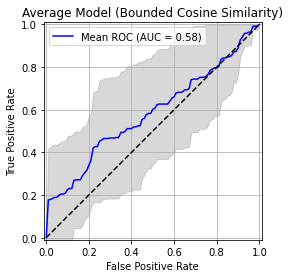

Mean EER: 0.46613219851220816 +- 0.07058230009354947
EERs:$44.55$ & $44.27$ & $56.85$ & $38.85$ & $39.75$ & $55.40$& $46.61 \pm 7.06$\\


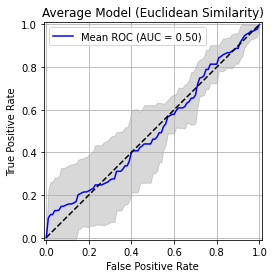

Mean EER: 0.3126610856392628 +- 0.05583273668643074
EERs:$24.24$ & $27.78$ & $36.84$ & $40.00$ & $31.71$ & $27.03$& $31.27 \pm 5.58$\\


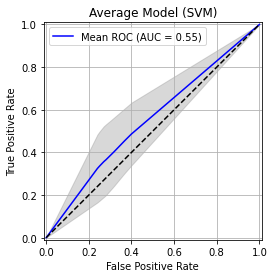

In [11]:
model = AverageModel("TP9", "TP10")
benchmark(model, filtered_data, bounded_cosine_similarity, "Average Model (Bounded Cosine Similarity)")
benchmark(model, filtered_data, euclidean_similarity, "Average Model (Euclidean Similarity)")
benchmark_svm(model, filtered_data, "Average Model (SVM)")

## Bandpower

Mean EER: 0.34250190607950376 +- 0.16221275097473786
EERs:$31.68$ & $11.45$ & $32.88$ & $65.61$ & $37.27$ & $26.62$& $34.25 \pm 16.22$\\


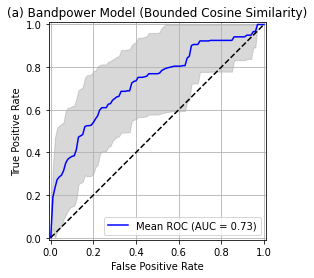

Mean EER: 0.444711503540066 +- 0.13170803887053484
EERs:$47.52$ & $23.66$ & $45.89$ & $54.14$ & $32.30$ & $63.31$& $44.47 \pm 13.17$\\


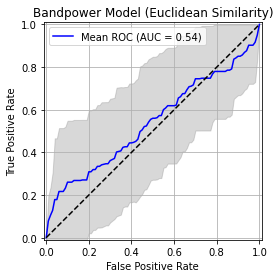

Mean EER: 0.07951157920670117 +- 0.1210804214479887
EERs:$6.06$ & $0.00$ & $0.00$ & $7.50$ & $34.15$ & $0.00$& $7.95 \pm 12.11$\\


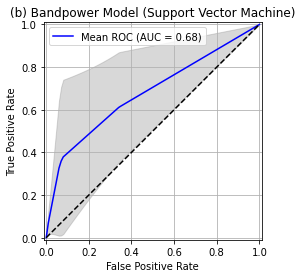

In [12]:
model = BandpowerModel()
benchmark(model, filtered_data, bounded_cosine_similarity, "(a) Bandpower Model (Bounded Cosine Similarity)")
benchmark(model, filtered_data, euclidean_similarity, "Bandpower Model (Euclidean Similarity)")
benchmark_svm(model, filtered_data, "(b) Bandpower Model (Support Vector Machine)")

## PACModel

Mean EER: 0.4000112499773543 +- 0.13950958434488034
EERs:$35.64$ & $13.74$ & $40.41$ & $59.87$ & $42.86$ & $47.48$& $40.00 \pm 13.95$\\


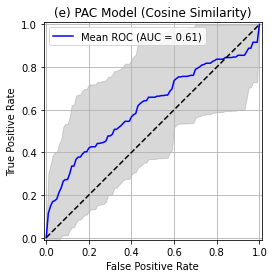

Mean EER: 0.521781302530372 +- 0.2014696647393634
EERs:$33.66$ & $21.37$ & $68.49$ & $80.89$ & $59.01$ & $49.64$& $52.18 \pm 20.15$\\


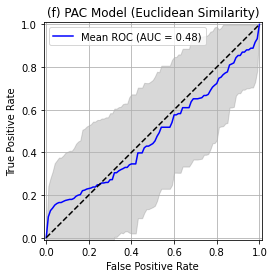

Mean EER: 0.13006759823191147 +- 0.06269608670922616
EERs:$12.12$ & $16.67$ & $7.89$ & $20.00$ & $2.44$ & $18.92$& $13.01 \pm 6.27$\\


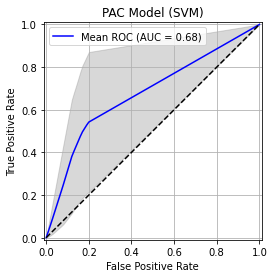

In [13]:
model = PACModel()
benchmark(model, filtered_data, bounded_cosine_similarity, "(e) PAC Model (Cosine Similarity)")
benchmark(model, filtered_data, euclidean_similarity, "(f) PAC Model (Euclidean Similarity)")
benchmark_svm(model, filtered_data, "PAC Model (SVM)")